
## ***Uncertainty Quantification***

Prof. Dr. M. Frank 2021

------------------------------------------------------------------------

#### **EXERCISE SHEET 4**

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import math
import scipy.linalg
import scipy.special

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   

**EXERCISE 1)**

A polynomial $p$ in two variables is said to have total degree of at most $n$ if it has the form

\begin{equation*}
p(x,y) = \sum_{i=0}^n\sum_{j=0}^{n-i} b_{ij}x^i y^j.
\end{equation*}

The coefficients $b_{ij}$ can be arranged in a natural triangular array of $\frac12(n+1)^2$ numbers.\\
Let $x_j$ and $y_j$ be two sets of $n+1$ distinct points, where $j=0,\dots,n$. Then we consider the array of points

\begin{equation*}
(x_i,y_j),\quad i+j=0,\dots,n.
\end{equation*}

(a)  Visualize the set of points. ***Hint:*** The points do not need to be ordered.

(b)  We try to find a polynomial $p(x,y)$ of total degree at most $n$ that interpolates arbitrary data of a function $f$ at these points. Show that

\begin{equation*}
f(x,y) = p(x,y)+R(x,y),
\end{equation*}

where

\begin{equation*}
p(x,y) = \sum_{i=0}^n \sum_{j=0}^{n-i} \omega_{i-1}(x)\omega_{j-1}(y)f[x_0,\dots,x_i;y_0,\dots,y_j]
\end{equation*}

and

\begin{equation*}
\begin{split}
R(x,y) &= \sum_{i=0}^n \omega_{i-1}(x)\omega_{n-i}(y) f[x_0,\dots,x_i;y_0,\dots,y_{n-i},y] + \omega_n(x)f[x_0,\dots,x_n,x;y] \\
&= \sum_{i=0}^{n+1} \frac{\omega_{i-1}(x)\omega_{n-i}(y)}{i! (n-i+1)!}\left(\frac{\partial}{\partial x}\right)^i \left(\frac{\partial}{\partial y}\right)^{n-i+1}f(\xi_i,\eta_i)
\end{split}
\end{equation*}

for some $\xi_i,\eta_i$.

(c)  Is this polynomial unique?

(d)  Is there a curse of dimensionality for this type of interpolation polynomial?


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   

**EXERCISE 2)**

Use the provided code to visualise and analyse the

- trapezoidal rule,
- Clenshaw-Curtis nodes,

With each of these quadrature rules, approximate the functions

(a) $x^{12}+x^3$,

(b) $x\cdot y^{4}+x$,

(c) $x\cdot y\cdot z^{14}$.

&nbsp;

In [2]:
#Run before Exercise to load helper functions

def applyQuadrature (f, q, w):
  if len(q.shape)==1:
    q=np.expand_dims(q,axis=0)
    
  dim = np.size(q,0)

  if dim == 1:
    integral=np.sum(np.multiply(f(q),w))
  elif dim == 2:
    integral = np.sum(np.multiply(f(q[0,:],q[1,:]),w))
  elif dim == 3:
    integral = np.sum(np.multiply(f(q[0,:],q[1,:],q[2,:]),w))
  else:
    raise ValueError("Functions not yet implemented for {0} dimensions".format(dim))

  return integral

def tensorizePointSet(x,y):
  #x is vector or (nxm) matrix, y is vector
  #returns matrix containing x_i yj for all i,j combinations
  s = x.shape
  if len(s)==1:
    x=np.expand_dims(x,axis=0)
    s = x.shape
  n = s[0]
  m = s[1]
  z=np.empty((n+1,m*np.size(y)))
  k=0
  for i in range(m):
    for j in range(np.size(y)):
      if n==1:
        z[:,k]=np.squeeze(np.vstack((x[:,i],y[j])))
        k=k+1
      else:
        z[:,k]=np.squeeze(np.hstack((x[:,i],y[j])))
        k=k+1
  
  return z

def tensorizeWeightSet (x,y):
  #x,y are vectors
  #returns matrix z of weights, containing x_i,y_j for all combinations of i,j
  z=np.empty((1,np.size(x)*np.size(y)))

  if len(x.shape)==1:
    x=np.expand_dims(x,axis=0)
  if len(y.shape)==1:
    y=np.expand_dims(y,axis=0)

  k=0
  for i in range(np.size(x)):
    for j in range(np.size(y)):
      #z = np.hstack((z, x[:,i]*y[:,j]))
      z[:,k]=x[:,i]*y[:,j]
      k = k+1
  return z 

In [3]:
#Implement quadrature rules

#trapezoidal
def trap(l):
  if l == 0:
    q=0.5
    w=0
  else:
    n = 2**(l-1)+1
    dx = 1/(n-1)
    q = np.arange(n)*dx

    if n == 2:
      tmp = 1
    else:
      tmp = 2/(n-2)*2/2

    w = 2*np.ones((1,n))*tmp
    w[:,0] = tmp
    w[:,np.size(w)-1] = tmp
    w = 2/np.sum(w)*w
    w = w/np.sum(w)

  return q,w

#Clenshaw-Curtis
def cc(l):
  if l == 0:
    q = 0.5
    w = 0
  
  else:
    q = 1/2* (1-np.cos((math.pi*np.arange(1,2**(l-1)+2) - math.pi)/2**(l-1)))
    n = np.size(q)-1
    def b(j):
      return 1 * (j==n/2) + 2 * (j<n/2)
    
    def c(k):
      return 1* (k%n==0) + 2 * (k%n!=0)
    
    w = np.zeros((1,n+1))

    for k in range(n+1):
      tmp = 0
      for j in range(1,math.floor(n/2)+1):
        tmp = tmp + b(j)/(4*j**2-1)*np.cos(2*j*(k*math.pi/n))
      w[:,k] = c(k)/n*(1-tmp)

    w = w/np.sum(w)

  return q,w
    
    
#Return all points of sparse quadrature 
def getAllNodesWeights(dim, l, sparseflag):
  if l == 0:
    q = np.ones((dim,1))
    w = 0
  
  else:
    #1D
    if dim == 1:
      q,w = quadrule(l)
    elif dim == 2:
      q=np.empty((2,1))
      w=np.empty((1,1))
      for i in range(1,l+dim):
        for j in range(1,l+dim):
          if sparseflag:
            if i+j<=l+dim-1:
              qi, wi = quadrule(i)
              if i>1:
                qi_low, wi_low = quadrule(i-1)
                wi[:,0::2] = wi[:,0::2] - wi_low
              qj, wj = quadrule(j)
              if j>1:
                qj_low, wj_low = quadrule(j-1)
                wj[:,0::2] = wj[:,0::2] - wj_low
            
              qij = tensorizePointSet(qi,qj)
              wij = tensorizeWeightSet(wi,wj)
              q = np.hstack((q,qij))
              w = np.hstack((w,wij))
          else:
            if max(i,j)<=l:
              qi, wi = quadrule(i)
              if i>1:
                qi_low, wi_low = quadrule(i-1)
                wi[:,0::2] = wi[:,0::2] - wi_low
              qj, wj = quadrule(j)
              if j>1:
                qj_low, wj_low = quadrule(j-1)
                wj[:,0::2] = wj[:,0::2] - wj_low
              qij = tensorizePointSet(qi,qj)
              wij = tensorizeWeightSet(wi,wj)
              q = np.hstack((q,qij))
              w = np.hstack((w,wij))
  
      q = np.delete(q,0,1)
      w = np.delete(w,0,None)

    elif dim == 3:
        q=np.empty((3,1))
        w=np.empty((1,1))
        for i in range(1,dim+l):
          for j in range(1,dim+l):
            for k in range(1,dim+l):
              if sparseflag:
                if i+j+k <=l+dim-1:
                  qi,wi = quadrule(i)
                  if i>1:
                    qi_low, wi_low = quadrule(i-1)
                    wi[:,0::2] = wi[:,0::2] - wi_low
                  qj, wj = quadrule(j)
                  if j>1:
                    qj_low, wj_low = quadrule(j-1)
                    wj[:,0::2] = wj[:,0::2] - wj_low
                  qk, wk = quadrule(k)
                  if k>1:
                    qk_low, wk_low = quadrule(k-1)
                    wk[:,0::2] = wk[:,0::2] - wk_low
                  qij = tensorizePointSet(qi,qj)
                  wij = tensorizeWeightSet(wi,wj)
                  qijk = tensorizePointSet(qij,qk)
                  wijk = tensorizeWeightSet(wij,wk)
                  q = np.hstack((q,qijk))
                  w = np.hstack((w,wijk))
              else:
                if max([i,j,k])<=l:
                  qi,wi = quadrule(i)
                  if i>1:
                    qi_low, wi_low = quadrule(i-1)
                    wi[:,0::2] = wi[:,0::2] - wi_low
                  qj, wj = quadrule(j)
                  if j>1:
                    qj_low, wj_low = quadrule(j-1)
                    wj[:,0::2] = wj[:,0::2] - wj_low
                  qk, wk = quadrule(k)
                  if k>1:
                    qk_low, wk_low = quadrule(k-1)
                    wk[:,0::2] = wk[:,0::2] - wk_low
                  qij = tensorizePointSet(qi,qj)
                  wij = tensorizeWeightSet(wi,wj)
                  qijk = tensorizePointSet(qij,qk)
                  wijk = tensorizeWeightSet(wij,wk)
                  q = np.hstack((q,qijk))
                  w = np.hstack((w,wijk))
        q = np.delete(q,0,1)
        w = np.delete(w,0,None)
    else:
        raise ValueError("Higher dimensions than 3D not yet implemented")

  w = w/np.sum(w)
  return q,w
      


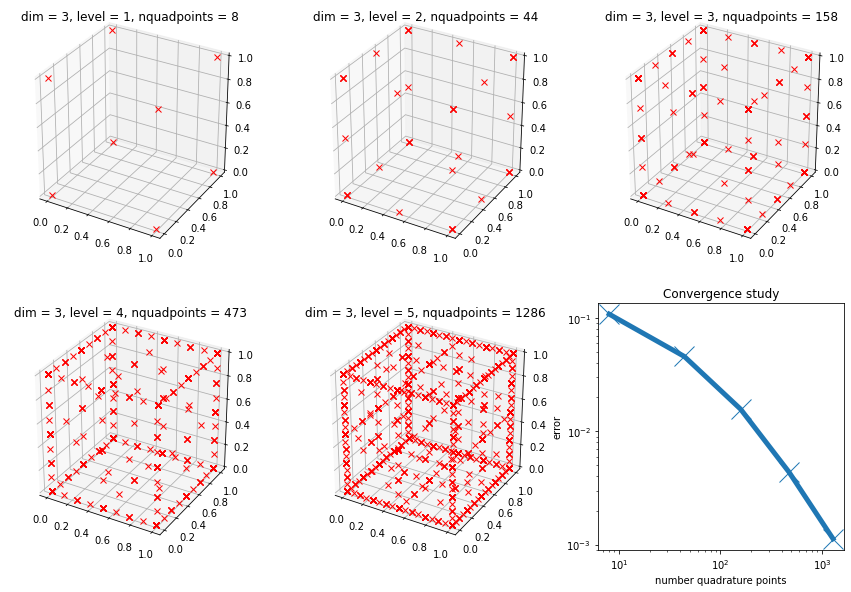

In [7]:
#Set-up
dim = 3   #number of spatial dimensions
l = 5   #level

sparseflag = True #sparse or tensorized grid

def quadrule (l):
  q,w = trap(l) #trapezoidal quad. rule
  #q,w = cc(l)   #cc quad. rule
  return q,w 

def f1(x):
  return x**12 + x**3 #TODO: function a)
def f2(x,y):
  return x*y**4 + x #TODO: function b)
def f3(x,y,z):
  return x * y * z**14 #TODO: function c)

f1=np.vectorize(f1)
f2=np.vectorize(f2)
f3=np.vectorize(f3)

#compute high order reference solution
f1integral,_ = integrate.quad(f1,0,1,epsabs=1e-16)
f2integral,_ = integrate.dblquad(f2,0,1,0,1,epsabs=1e-16)
f3integral,_ = integrate.tplquad(f3,0,1,0,1,0,1,epsabs=1e-16)

nl = np.zeros((l,1))
err = np.zeros((l,1))

#Apply the quadrature
#1D
if dim == 1: 
  fig, ax = plt.subplots(nrows=2,ncols=math.ceil((l+1)/2),figsize=(math.ceil((l+1)/2)*5,10))
  fig.subplots_adjust(wspace=0.3,hspace=0.3)
  for level in range(1,l+1):
    q,w = getAllNodesWeights(dim,level,sparseflag)

    ax[math.floor((level-1)/math.ceil((l+1)/2)),(level-1)%math.ceil((l+1)/2)].plot(q,np.ones(np.size(q))/2,'x',color='red')
    ax[math.floor((level-1)/math.ceil((l+1)/2)),(level-1)%math.ceil((l+1)/2)].set_title("dim = {0}, level = {1}, nquadpoints = {2}".format(dim,level,np.size(q)))

    nl[level-1] = np.size(q)
    err[level-1] = np.linalg.norm(f1integral - applyQuadrature(f1,q,w))

  err = err + 1e-16 #so that result can be plotted even though error is zero
  ax[1,np.size(ax,1)-1].loglog(nl,err,'-x',linewidth=5,markersize=20)
  ax[1,np.size(ax,1)-1].set_xlabel("number quadrature points")
  ax[1,np.size(ax,1)-1].set_ylabel("error")
  ax[1,np.size(ax,1)-1].set_title("Convergence study")

#2D
elif dim == 2:
  fig, ax = plt.subplots(nrows=2,ncols=math.ceil((l+1)/2),figsize=(math.ceil((l+1)/2)*5,10))
  fig.subplots_adjust(wspace=0.3,hspace=0.3)
  for level in range(1,l+1):
    q,w = getAllNodesWeights(dim,level,sparseflag)
    ax[math.floor((level-1)/math.ceil((l+1)/2)),(level-1)%math.ceil((l+1)/2)].plot(q[0,:],q[1,:],'x',color='red')
    ax[math.floor((level-1)/math.ceil((l+1)/2)),(level-1)%math.ceil((l+1)/2)].set_title("dim = {0}, level = {1}, nquadpoints = {2}".format(dim,level,np.size(q,1)))

    nl[level-1] = np.size(q,1)
    err[level-1] = np.linalg.norm(f2integral - applyQuadrature(f2,q,w))

  err = err + 1e-16 #so that result can be plotted even though error is zero
  ax[1,np.size(ax,1)-1].loglog(nl,err,'-x',linewidth=5)
  ax[1,np.size(ax,1)-1].set_xlabel("number quadrature points")
  ax[1,np.size(ax,1)-1].set_ylabel("error",rotation=90,labelpad=0)
  ax[1,np.size(ax,1)-1].set_title("Convergence study")

#3D
elif dim == 3:
  fig = plt.figure(figsize=(math.ceil((l+1)/2)*5,10))
  for level in range(1,l+1):
    q,w = getAllNodesWeights(dim,level,sparseflag)
    ax = fig.add_subplot(2,math.ceil((l+1)/2),level, projection='3d')
    ax.plot(q[0,:],q[1,:],q[2,:],'x',color='red')
    ax.set_title("dim = {0}, level = {1}, nquadpoints = {2}".format(dim,level,np.size(q,1)))

    nl[level-1] = np.size(q,1)
    err[level-1] = np.linalg.norm(f3integral - applyQuadrature(f3,q,w))
  
  err = err + 1e-16 #so that result can be plotted even though error is zero
  ax = fig.add_subplot(2,math.ceil((l+1)/2),level+1)
  ax.loglog(nl,err,'-x',linewidth=5,markersize=20)
  ax.set_xlabel("number quadrature points")
  ax.set_ylabel("error")
  ax.set_title("Convergence study")

